<h3>Load helper functions</h3>

In [1]:
%run _utils.ipynb

<h3>Load Greenkeeper In-Range Breaking Build <code>issues</code></h3>

In [2]:
gk_issues = load_gk_issues_for_analysis()
comments = load_comments()

<h2><b>Pinning</b></h2>

In [3]:
pinning_comments = (
    comments.loc[
        (comments['comment_user_type'] == 'Bot') &
        (comments['comment_user_login'] == 'greenkeeper[bot]') &
        (comments['comment_body'].str.contains('After pinning to', case=False))
    ][
        ['comment_issue_id', 'comment_url', 'comment_body']
    ]
)

issue_pin_status = pinning_comments.merge(
    gk_issues[['id', 'url', 'title', 'html_url', 'body']],
    left_on='comment_issue_id',
    right_on='id'
)
# Re-order columns
issue_pin_status = issue_pin_status[['id', 'url', 'title', 'html_url', 'body', 'comment_issue_id', 'comment_url', 'comment_body']]

<h3>How often do pinning attempts happen?</h3>

In [4]:
per = calculate_percent(issue_pin_status['id'].nunique(), gk_issues['id'].nunique())
print(f'{per}% of GKIRs have a pinning attempt')

issues_without_pin_attempt = gk_issues[~gk_issues['id'].isin(issue_pin_status['id'])]
per = calculate_percent(
    issues_without_pin_attempt['id'].nunique(),
    gk_issues['id'].nunique()
)

print(f'{per}% of GKIRs dont have a pinning attempt')

80.32% of GKIRs have a pinning attempt
19.68% of GKIRs dont have a pinning attempt


<h3>What are the issues that dont have a pin attempt?</h3>

In [6]:
bundled_issues_without_pin_attempt = (
    issues_without_pin_attempt
        .groupby('id')
        .filter(lambda df: len(df) > 1)
)
per = calculate_percent(
    bundled_issues_without_pin_attempt["id"].nunique(),
    issues_without_pin_attempt['id'].nunique()
)
print(f'{per}% of GKIRs without a pin attempt are bundled')


single_issues_without_pin_attempt = (
    issues_without_pin_attempt
        .groupby('id')
        .filter(lambda df: len(df) == 1)
)
per = calculate_percent(
    single_issues_without_pin_attempt["id"].nunique(),
    issues_without_pin_attempt['id'].nunique()
)
print(f'{per}% of GKIRs without a pin attempt are single issues')

16.83% of GKIRs without a pin attempt are bundled
83.17% of GKIRs without a pin attempt are single issues


In [7]:
# single_issues_without_pin_attempt.sort_values(by='created_at')[['created_at', 'html_url']].tail(20)
# single_issues_without_pin_attempt.hist(column='created_at', bins=20)
# single_issues_without_pin_attempt['repo_name'].value_counts()

<h3>Quick look at bundling stats</h3>

In [8]:
bundled_issues = (
    gk_issues
        .groupby('id')
        .filter(lambda df: len(df) > 1)
)

per = calculate_percent(
    bundled_issues["id"].nunique(),
    gk_issues['id'].nunique()
)
print(f'{per}% of GKIRs are bundled')


single_issues = (
    gk_issues
        .groupby('id')
        .filter(lambda df: len(df) == 1)
)
per = calculate_percent(
    single_issues["id"].nunique(),
    gk_issues['id'].nunique()
)
print(f'{per}% of GKIRs are single issues')

4.25% of GKIRs are bundled
95.75% of GKIRs are single issues


In [9]:
bundled_issues_wo_pin = bundled_issues[
    ~bundled_issues['id'].isin(issue_pin_status['id'])
]
per = calculate_percent(
    bundled_issues_wo_pin["id"].nunique(),
    gk_issues['id'].nunique()
)
print(f'{per}% of GKIRs are bundled and do not have a pin attempt')
per = calculate_percent(
    bundled_issues_wo_pin["id"].nunique(),
    bundled_issues['id'].nunique()
)
print(f'{per}% of bundled GKIRS do not have a pin attempt')

bundled_issues_w_pin = bundled_issues[
    bundled_issues['id'].isin(issue_pin_status['id'])
]
per = calculate_percent(
    bundled_issues_w_pin["id"].nunique(),
    gk_issues['id'].nunique()
)
print(f'{per}% of GKIRs are bundled and have a pin attempt')
per = calculate_percent(
    bundled_issues_w_pin["id"].nunique(),
    bundled_issues['id'].nunique()
)
print(f'{per}% of bundled GKIRS do have a pin attempt')

3.31% of GKIRs are bundled and do not have a pin attempt
77.9% of bundled GKIRS do not have a pin attempt
0.94% of GKIRs are bundled and have a pin attempt
22.1% of bundled GKIRS do have a pin attempt


<h3>Any correlation between time to close and number of comments?</h3>

In [10]:
gkirs = (
    gk_issues[
        gk_issues['state'] == 'closed'
    ][['id', 'created_at', 'closed_at', 'num_comments']]
    .copy()
)
gkirs['time_to_close'] = (
    gkirs['closed_at'] - gkirs['created_at']
)
gkirs['time_to_close_hours'] = (
    gkirs['time_to_close'] / np.timedelta64(1, 'h')
)

gkirs = gkirs[gkirs['num_comments'] > 0]
gkirs = gkirs[gkirs['time_to_close_hours'] > 0]

gkirs['log_time_to_close_hours'] = np.log10(gkirs['time_to_close_hours'])
gkirs['log_num_comments'] = np.log10(gkirs['num_comments'])

gkirs.describe()

,id,num_comments,time_to_close,time_to_close_hours,log_time_to_close_hours,log_num_comments
count,7.261200e+04,72612.000000,72612,72612.000000,72612.000000,72612.000000
mean,3.975602e+08,4.038244,45 days 17:38:32.280656090,1097.642300,1.970864,0.297031
std,1.032159e+08,27.993909,101 days 09:46:05.748816815,2433.768264,1.244715,0.381545
min,1.849240e+08,1.000000,0 days 00:00:15,0.004167,-2.380211,0.000000
25%,3.222962e+08,1.000000,0 days 11:18:54.250000,11.315069,1.053657,0.000000
50%,4.019324e+08,2.000000,5 days 10:20:54,130.348333,2.115105,0.301030
75%,4.691531e+08,3.000000,39 days 19:34:11,955.569722,2.980262,0.477121
max,6.297412e+08,2392.000000,1219 days 02:01:10,29258.019444,4.466245,3.378761


Saving figure time_to_close_vs_num_of_comments


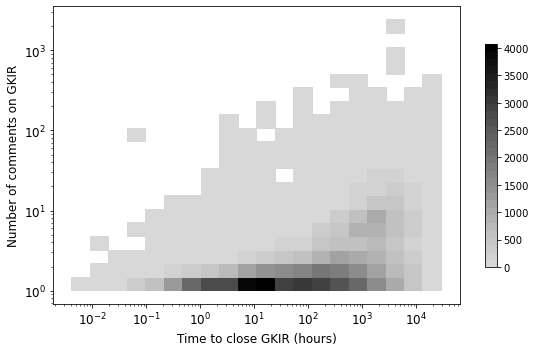

In [11]:
# gkirs.plot.scatter(x='log_time_to_close_hours', y='log_num_comments')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

# cmap = plt.get_cmap('Greys')
cmap = mpl.cm.Greys(np.linspace(0,1,40))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
sns.histplot(
    data=gkirs,
    x='time_to_close_hours',
    y='num_comments',
    ax=ax,
    bins=20,
    log_scale=(True, True),
    cmap=cmap,
    cbar=True,
    cbar_kws=dict(shrink=.75),
)
ax.set_xlabel('Time to close GKIR (hours)', fontsize=12)
ax.set_ylabel('Number of comments on GKIR', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

save_fig('time_to_close_vs_num_of_comments')

plt.show()

<h3><b><i>How successful is auto-pinning the dependency?</i></b></h3>

In [12]:
issue_pin_status['pin_status'] = 'unknown'
pin_fail_regex = '|'.join([
    "your tests are still failing",
])
pin_success_regex = '|'.join([
    "your tests are passing again"
])
issue_pin_status.loc[
    issue_pin_status['comment_body'].str.contains(pin_success_regex, case=False),
    'pin_status'
] = 'success'
issue_pin_status.loc[
    issue_pin_status['comment_body'].str.contains(pin_fail_regex, case=False),
    'pin_status'
] = 'failure'

issue_pin_status['pin_status'].value_counts()

proportions = (
    issue_pin_status['pin_status'].value_counts() / 
    issue_pin_status['pin_status'].count()
).to_frame(name='proportion')\
    .rename_axis('pin_status')\
    .reset_index()
print('--How successful is pinning the dependency?--')
proportions.head()

--How successful is pinning the dependency?--


,pin_status,proportion
0,failure,0.676202
1,success,0.323798


<h4>Write out cases for manual analysis</h4>

In [13]:
# failed_pins = issue_pin_status[issue_pin_status['pin_status'] == 'failure']
# # failed_pins.info()
# sample_failed_pins = failed_pins.sample(n=800, random_state=42)
# sample_failed_pins.to_csv(f'./manual_analysis/failed_pins/sample_failed_pins.csv', index=False)

<h3>What are the types of dependencies for failed vs successful pin attempts?</h3>

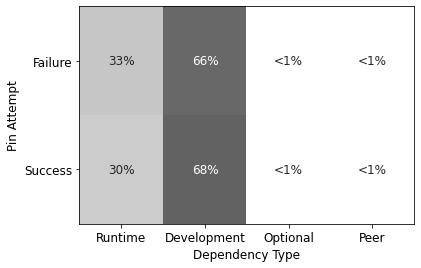

In [14]:
with_dependency_type = issue_pin_status.merge(
    gk_issues[['id', 'dependency_type']],
    how='left',
    on='id'
)

dependency_type_by_pin_status = with_dependency_type.groupby('pin_status')['dependency_type']

dependency_type_by_pin_status = (
    dependency_type_by_pin_status.value_counts() / 
    dependency_type_by_pin_status.count()
#     with_dependency_type['dependency_type'].value_counts().sum()
).unstack()

import math
def make_label(x):
    label = f'{math.floor(x * 100)}%'
    if label == '0%':
        label = '<1%'
    return label
        
dependency_type_by_pin_status_labels = dependency_type_by_pin_status.applymap(lambda x: make_label(x))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

sns.heatmap(
    dependency_type_by_pin_status,
    annot=dependency_type_by_pin_status_labels,
    annot_kws={
        'fontsize': 12
    },
    fmt='',
    cbar=False,
    square=False,
    ax=ax,
    cmap=plt.get_cmap('Greys'),
    vmin=0,
    vmax=1,
)

ax.set_xlabel('Dependency Type', fontsize=12)
ax.set_xticklabels(['Runtime', 'Development', 'Optional', 'Peer'], rotation=0, fontsize=12)

ax.set_ylabel('Pin Attempt', fontsize=12)
ax.set_yticklabels(['Failure', 'Success'], rotation=0, fontsize=12)

for _, spine in ax.spines.items():
    spine.set_visible(True)

    
# save_fig('')

plt.show()


In [15]:
issue_pin_status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76486 entries, 0 to 76485
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                76486 non-null  int64 
 1   url               76486 non-null  object
 2   title             76486 non-null  object
 3   html_url          76422 non-null  object
 4   body              76422 non-null  object
 5   comment_issue_id  76486 non-null  int64 
 6   comment_url       76486 non-null  object
 7   comment_body      76486 non-null  object
 8   pin_status        76486 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.8+ MB


<h4>Do success/fail pins predict whether a new release will fix the issue?</h4>

In [16]:
succ_pin_issue_ids = issue_pin_status[issue_pin_status['pin_status'] == 'success']['id'].unique()
fail_pin_issues_ids = issue_pin_status[issue_pin_status['pin_status'] == 'failure']['id'].unique()

gk_comments = comments.loc[
    (
        (comments['comment_user_type'] == 'Bot') &
        (comments['comment_user_login'] == 'greenkeeper[bot]')
    )
]
# Get comments for issues with successful pins
succ_pin_gk_comments = gk_comments[gk_comments['comment_issue_id'].isin(succ_pin_issue_ids)]

failing_with_new_release_regex = 'Your tests are still failing with this version'
passing_with_new_release_regex = 'Your tests are passing again with this version'


def comment_group_saw_new_release(comment_group):
    new_release_comments = comment_group[
        (comment_group['comment_body'].str.contains(failing_with_new_release_regex)) |
        (comment_group['comment_body'].str.contains(passing_with_new_release_regex))
    ]
    return len(new_release_comments) > 0

def issue_has_passing_with_new_release_comment(comment_group):
    new_passing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(passing_with_new_release_regex)
    ]
    return len(new_passing_release_comments) > 0

def issue_has_failing_with_new_release_comment(comment_group):
    new_failing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(failing_with_new_release_regex)
    ]
    return len(new_failing_release_comments) > 0

def issue_has_only_failing_new_release_comments(comment_group):
    return (
        not issue_has_passing_with_new_release_comment(comment_group) and
        issue_has_failing_with_new_release_comment(comment_group)
    )

def issue_has_only_passing_new_release_comments(comment_group):
    return (
        issue_has_passing_with_new_release_comment(comment_group) and
        not issue_has_failing_with_new_release_comment(comment_group)
    )

print('SUCCESSFUL PINS')

# Only issues that saw new release
succ_pin_comments_with_new_release = \
    succ_pin_gk_comments\
        .groupby('comment_issue_id')\
        .filter(comment_group_saw_new_release)

succ_pin_comments_with_new_release_count = (
    succ_pin_comments_with_new_release['comment_issue_id']
        .nunique()
)

passing_with_new_release = (
    succ_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_passing_with_new_release_comment)
)
issues_with_passing_new_release_count = (
    passing_with_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_passing_new_release_count,
    succ_pin_comments_with_new_release_count
)
print(f'{proportion}% ({issues_with_passing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt also eventually see a new passing release of the dependency')

only_failing_new_release = (
    succ_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_failing_new_release_comments)
)
issues_with_only_failing_new_release_count = (
    only_failing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_failing_new_release_count,
    succ_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_failing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )
''')

only_passing_new_release = (
    succ_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_passing_new_release_comments)
)
issues_with_only_passing_new_release_count = (
    only_passing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_passing_new_release_count,
    succ_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_passing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )
''')

SUCCESSFUL PINS
38.1% (2980/7822) of issues with a successful pin attempt also eventually see a new passing release of the dependency
61.9% (4842/7822) of issues with a successful pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )

26.51% (2074/7822) of issues with a successful pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )



In [17]:
# Only issues that saw new release
succ_pin_comments_with_new_release = \
    succ_pin_gk_comments\
        .groupby('comment_issue_id')\
        .filter(comment_group_saw_new_release)

succ_pin_comments_with_new_release_count = (
    succ_pin_comments_with_new_release['comment_issue_id']
        .nunique()
)


only_failing_new_release = (
    succ_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_failing_new_release_comments)
)
issues_with_only_failing_new_release_count = (
    only_failing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_failing_new_release_count,
    succ_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_failing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )
''')

only_passing_new_release = (
    succ_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_passing_new_release_comments)
)
issues_with_only_passing_new_release_count = (
    only_passing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_passing_new_release_count,
    succ_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_passing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )
''')



61.9% (4842/7822) of issues with a successful pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )

26.51% (2074/7822) of issues with a successful pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )



In [18]:
print('FAIL PINS')

fail_pin_gk_comments = gk_comments[gk_comments['comment_issue_id'].isin(fail_pin_issues_ids)]

fail_pin_comments_with_new_release = (
    fail_pin_gk_comments
        .groupby('comment_issue_id')
        .filter(comment_group_saw_new_release)
)

fail_pin_comments_with_new_release_count = (
    fail_pin_comments_with_new_release['comment_issue_id']
        .nunique()
)

passing_with_new_release = (
    fail_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_passing_with_new_release_comment)
)
issues_with_passing_new_release_count = (
    passing_with_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_passing_new_release_count,
    fail_pin_comments_with_new_release_count
)
print(f'{proportion}% ({issues_with_passing_new_release_count}/{fail_pin_comments_with_new_release_count}) \
of issues with a failing pin attempt also eventually see a new passing release of the dependency')

only_failing_new_release = (
    fail_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_failing_new_release_comments)
)
issues_with_only_failing_new_release_count = (
    only_failing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_failing_new_release_count,
    fail_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_failing_new_release_count}/{fail_pin_comments_with_new_release_count}) \
of issues with a failing pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )
''')

only_passing_new_release = (
    fail_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_passing_new_release_comments)
)
issues_with_only_passing_new_release_count = (
    only_passing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_passing_new_release_count,
    fail_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_passing_new_release_count}/{fail_pin_comments_with_new_release_count}) \
of issues with a failing pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )
''')

FAIL PINS
8.83% (1757/19909) of issues with a failing pin attempt also eventually see a new passing release of the dependency
91.17% (18152/19909) of issues with a failing pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )

4.62% (920/19909) of issues with a failing pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )



<h3>Does Greenkeeper pin to the latest available in range version? Or just remove the ranger operator from the statement?</h3>

In [174]:
with_dependency_info = issue_pin_status[['id', 'html_url', 'pin_status']].merge(
    gk_issues[['id', 'dependency_name', 'dependency_actual_version', 'dependency_next_version']],
    how='left',
    on='id'
)
with_dependency_info = with_dependency_info.dropna()

with_dependency_info.sample(10)

,id,html_url,pin_status,dependency_name,dependency_actual_version,dependency_next_version
56951,376271707,https://github.com/videojs/m3u8-parser/issues/62,success,conventional-changelog-cli,2.0.5,2.0.7
43120,411160748,https://github.com/recruit-tech/redux-pluto/issues/311,failure,enzyme-adapter-react-16,1.9.0,1.9.1
8227,538326153,https://github.com/yurikrupniktools/client-apps/issues/194,failure,webpack,4.41.2,4.41.3
55298,380036270,https://github.com/redgeoff/mson-getting-started/issues/19,success,react-dom,16.6.1,16.6.2
19311,477857560,https://github.com/rdfostrich/comunica-actor-init-sparql-ostrich/issues/58,failure,@types/node,12.6.9,12.7.0
58552,368851772,https://github.com/rxreact/core/issues/39,success,@types/jest,23.3.5,23.3.6
13770,504158371,https://github.com/footageone/angular-material-addons/issues/18,failure,ng-packagr,5.5.1,5.6.0
17124,483850177,https://github.com/dooboolab/talktalk-rn/issues/84,success,react-native-gesture-handler,1.3.0,1.4.0
37392,420792149,https://github.com/GregBrimble/gregbrimble.com/issues/5,success,gatsby-plugin-manifest,2.0.23,2.0.24
5165,564387366,https://github.com/jstransformers/jstransformer-fest/issues/14,success,xo,0.25.4,0.26.0
